Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D



In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height, img_width, 32)

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  seed=123,
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-06-14 06:29:15.534615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  seed=123,
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  seed=123,
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds
print(class_names)

train_ds_unbatch = train_ds.unbatch()
images = list(train_ds_unbatch.map(lambda x, y: x))
labels = list(train_ds_unbatch.map(lambda x, y: y))
print(images)
print(labels)
#labels = train_ds_list.map(lambda x, y: y)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

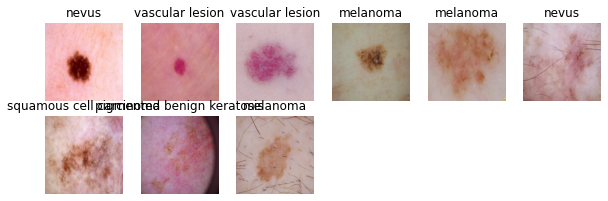

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 115s 2s/step - loss: 2.0664 - accuracy: 0.1881 - val_loss: 1.9946 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 107s 2s/step - loss: 1.9618 - accuracy: 0.2539 - val_loss: 1.8618 - val_accuracy: 0.2886
Epoch 3/20
56/56 [==============================] - 128s 2s/step - loss: 1.8198 - accuracy: 0.3287 - val_loss: 1.7118 - val_accuracy: 0.3982
Epoch 4/20
56/56 [==============================] - 107s 2s/step - loss: 1.7659 - accuracy: 0.3571 - val_loss: 1.6995 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 107s 2s/step - loss: 1.6931 - accuracy: 0.3532 - val_loss: 1.6008 - val_accuracy: 0.4318
Epoch 6/20
56/56 [==============================] - 108s 2s/step - loss: 1.5942 - accuracy: 0.4241 - val_loss: 1.8560 - val_accuracy: 0.3266
Epoch 7/20
56/56 [==============================] - 107s 2s/step - loss: 1.5834 - accuracy: 0.4152 - val_loss: 1.5130 - val_accuracy: 0.4743
Epoch 8/20
56/56 [======

### Visualizing training results

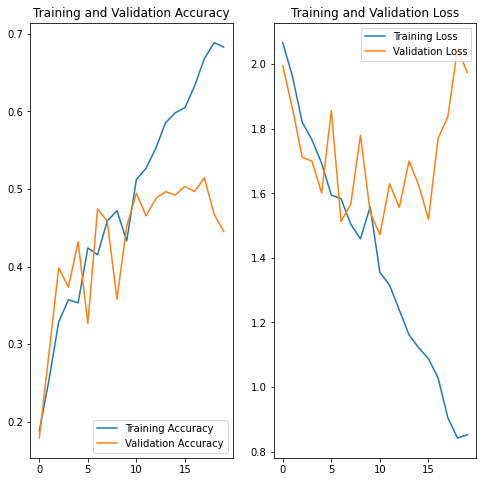

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

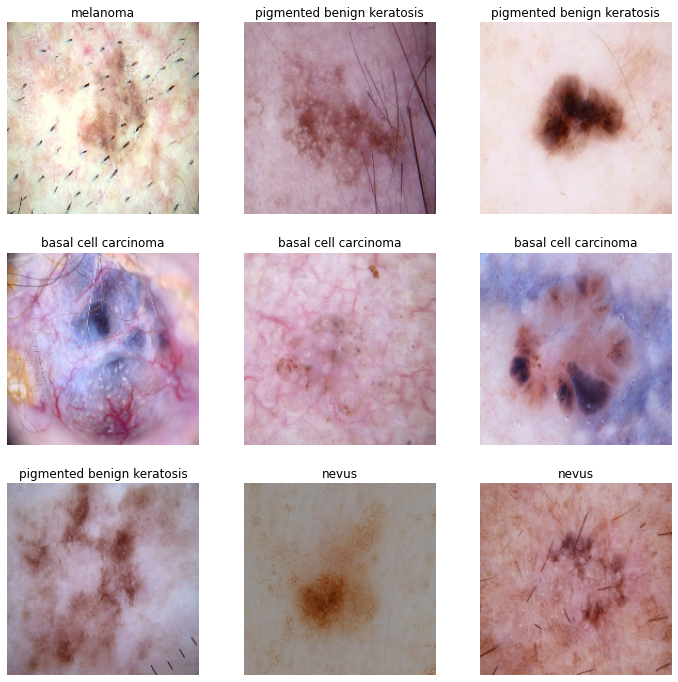

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 124s 2s/step - loss: 2.0633 - accuracy: 0.2154 - val_loss: 1.9458 - val_accuracy: 0.2931
Epoch 2/30
56/56 [==============================] - 125s 2s/step - loss: 1.9253 - accuracy: 0.2734 - val_loss: 1.9339 - val_accuracy: 0.2953
Epoch 3/30
56/56 [==============================] - 126s 2s/step - loss: 1.8552 - accuracy: 0.3242 - val_loss: 1.8654 - val_accuracy: 0.3020
Epoch 4/30
56/56 [==============================] - 126s 2s/step - loss: 1.7707 - accuracy: 0.3499 - val_loss: 1.8130 - val_accuracy: 0.3043
Epoch 5/30
56/56 [==============================] - 126s 2s/step - loss: 1.6977 - accuracy: 0.3717 - val_loss: 1.6377 - val_accuracy: 0.4385
Epoch 6/30
56/56 [==============================] - 128s 2s/step - loss: 1.6387 - accuracy: 0.4124 - val_loss: 1.5903 - val_accuracy: 0.4295
Epoch 7/30
56/56 [==============================] - 128s 2s/step - loss: 1.5344 - accuracy: 0.4576 - val_loss: 1.5235 - val_accuracy: 0.4586
Epoch 8/30
56

### Visualizing the results

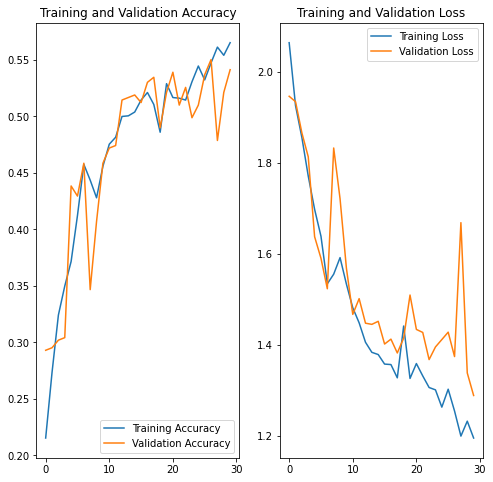

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
1,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
2,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
3,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
4,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
...,...,...
2234,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2235,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2236,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2237,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion


In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
1,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
2,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
3,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
4,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
...,...,...
2234,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2235,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2236,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
2237,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion


<BarContainer object of 9 artists>

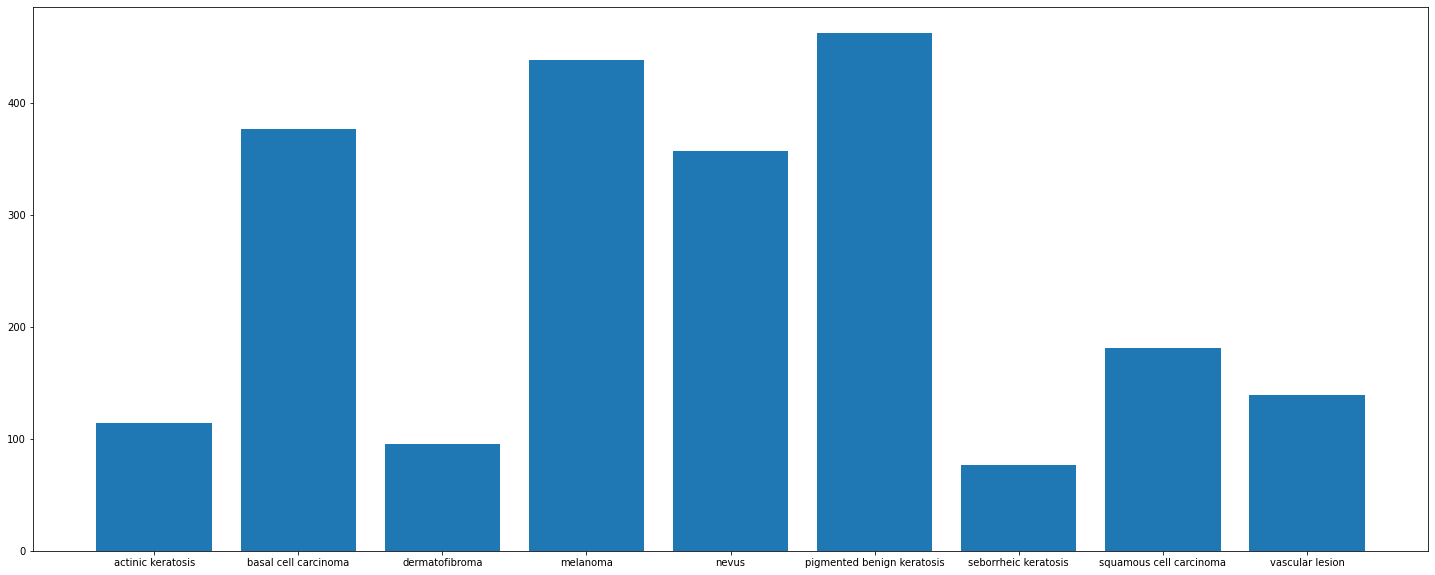

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

Answer-1 :- Seborthiec keratosis has least number of samples

Answer-2:- base cell carcinoma and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [31]:
import  Augmentor

In [28]:
pip install Augmentor

  Using cached Augmentor-0.2.10-py2.py3-none-any.whl (38 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=983719d13516f1a222c39103c41d5c4619be59d924c958c879a28f73372475b3
  Stored in directory: /Users/geetadesai/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [29]:

print(data_dir_train)

/Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset=data_dir_train

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x154AB4220>: 100%|██████████████████████████████████████████| 500/500 [00:06<00:00, 74.07 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14C272A30>: 100%|███████████████████████████████████████████| 500/500 [00:06<00:00, 73.57 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x14BB89BE0>: 100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 60.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x155EBDC10>: 100%|██████████████████████████████████████████| 500/500 [00:07<00:00, 64.54 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x154DDE220>: 100%|█████████████████████████| 500/500 [00:07<00:00, 70.97 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x14BDA5790>: 100%|█████████████████████████| 500/500 [00:07<00:00, 71.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14BD67790>: 100%|███████████████████████████████████████████| 500/500 [00:07<00:00, 68.06 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x155EBBAF0>: 100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 73.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x155DE3520>: 100%|███████████████████████████████████████████| 500/500 [00:06<00:00, 77.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
data_dir_train1 = pathlib.Path("/Users/geetadesai/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
1,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
2,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
3,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
4,/Users/geetadesai/Downloads/Skin cancer ISIC T...,actinic keratosis
...,...,...
6734,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
6735,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
6736,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion
6737,/Users/geetadesai/Downloads/Skin cancer ISIC T...,vascular lesion


In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    1401
melanoma                      1312
basal cell carcinoma          1149
nevus                         1083
squamous cell carcinoma        522
vascular lesion                430
actinic keratosis              352
dermatofibroma                 261
seborrheic keratosis           229
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


4500
Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [52]:
epochs = 30
## Your code goes here
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 258s 2s/step - loss: 2.0137 - accuracy: 0.2200 - val_loss: 1.8805 - val_accuracy: 0.2378
Epoch 2/30
113/113 [==============================] - 246s 2s/step - loss: 1.7569 - accuracy: 0.3517 - val_loss: 1.6462 - val_accuracy: 0.3978
Epoch 3/30
113/113 [==============================] - 261s 2s/step - loss: 1.5852 - accuracy: 0.4264 - val_loss: 1.4576 - val_accuracy: 0.4844
Epoch 4/30
113/113 [==============================] - 274s 2s/step - loss: 1.5045 - accuracy: 0.4669 - val_loss: 1.4693 - val_accuracy: 0.4733
Epoch 5/30
113/113 [==============================] - 273s 2s/step - loss: 1.3909 - accuracy: 0.5067 - val_loss: 1.3760 - val_accuracy: 0.5000
Epoch 6/30
113/113 [==============================] - 272s 2s/step - loss: 1.3167 - accuracy: 0.5269 - val_loss: 1.3392 - val_accuracy: 0.5133
Epoch 7/30
113/113 [==============================] - 258s 2s/step - loss: 1.3235 - accuracy: 0.5297 - val_loss: 1.4457 - val_accuracy: 0.4744
Epoch 8/30

#### **Todo:**  Visualize the model results

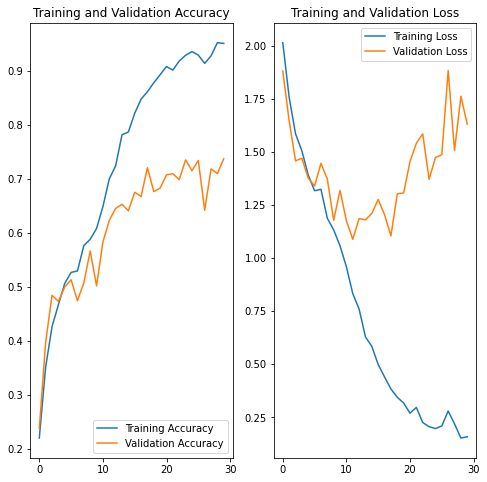

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter